Coordonnées sensible :
> 1.2895 47.1241  
> 1.2992 47.1293  
> -2.1234 47.9721  
> -0.4308 44.945  

# Conditions d'utilisations

* Le point renseigné par l'utilisateur doit se trouver dans une parcelle
* La parcelle doit se trouver dans un carré de 12,6 hectares centré sur le point indiqué par l'utilisateur 

Pour simplifier la réutilisation j'ai identifié toutes les modifications a faire par des #to_modify avec les descriptions associés

## Import librairies

In [1]:
import os
import io
import cv2
import time
import requests

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline

from shapely.geometry import Polygon

from typing import Union, Tuple 

from PIL import Image
from PIL.JpegImagePlugin import JpegImageFile

from ultralytics import YOLO
from ultralytics.engine.results import Results

## Import Image

In [2]:
def create_box(center: np.ndarray, offset: np.ndarray) -> np.ndarray:
    """create a coordinate box around the center of a random parcel

    Args:
        center (np.ndarray): Coordinates of the point
        offset (np.ndarray): box size

    Returns:
        np.ndarray: coordinate box
    """
    lower = center - offset/2
    upper = center + offset/2

    return np.array([lower, upper]).reshape(-1)

In [3]:
def _request(url: str) -> Union[requests.models.Response, None]:
    """api response

    Args:
        url (str): url request

    Returns:
        Union[requests.models.Response, None]: response
    """
    response = requests.get(url)
    if response.status_code != 200:
        sys.stderr.write(f"GET request failed. Status code: {response.status_code}\n")
        response = None
    return response

def _request_image_box(lon_min: np.float64, lat_min: np.float64, lon_max: np.float64, 
                       lat_max: np.float64, pixel: int, api_token: str) -> requests.models.Response:
    """api response for a satellite image

    Args:
        lon_min (np.float64): longitude min
        lat_min (np.float64): latitude min
        lon_max (np.float64): longitude max
        lat_max (np.float64): latitude max
        width (int): pixel width 
        height (int): pixel height
        api_token (str): API token

    Returns:
        requests.models.Response: response
    """
    url = f"https://api.mapbox.com/styles/v1/mapbox/satellite-v9/static/[{lon_min},{lat_min},{lon_max},{lat_max}]/{pixel}x{pixel}?logo=false&attribution=false&access_token={api_token}"
    return _request(url)

def _extract_content_from_reponse(response: requests.models.Response) -> Union[Tuple[JpegImageFile, str], Tuple[None, None]]:
    """image extraction from API response

    Args:
        response (requests.models.Response): API response

    Returns:
        Union[Tuple[JpegImageFile, str], Tuple[None, None]]: image with its format
    """
    result = (None, None)
    if response:
        content_type = response.headers["content-type"]
        format = content_type.split('/')[-1]
        image  = Image.open(io.BytesIO(response.content))
        
    return image, format

## Travail sur les masks

In [4]:
def filter_mask(results : Results) -> Union[np.ndarray, None]:
    """keep the mask we're interested (central mask) 

    Args:
        results (Results): model prediction

    Returns:
        Union[np.ndarray, None]: Central mask 
    """
    masks = results.masks.data.cpu().numpy().astype(np.uint8)
    masks = (masks * 255)

    conf = results.boxes.conf.data.cpu().numpy().astype(np.float32) 
    center_mask_bool = masks[:, 256, 256] == 255

    filtered_conf = conf[center_mask_bool]

    # Comptez le nombre de masques centrés
    num_center_masks = np.sum(center_mask_bool)
    print(f'Nombre de masque centré : {num_center_masks}')

    if num_center_masks > 0:
        max_conf_index = np.argmax(filtered_conf)
        return masks[center_mask_bool, :, :][max_conf_index]
    else:
        return None

In [5]:
def mask_cleaning(mask: np.ndarray, coef_seg: float) -> Union[np.ndarray, np.ndarray]:
    """mask cleaning and calculation of image coordinates 

    Args:
        mask (np.ndarray): central mask
        coef_seg (float): coef for polygon precision

    Returns:
        Union[np.ndarray, np.ndarray]: mask clean, polygon coordinates
    """
    # Création des contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #calcul d'air des contours
    areas = [cv2.contourArea(contour) for contour in contours]
    #récupération du contour le plus grand 
    max_index = np.argmax(areas)

    #création du nouveau mask
    new_mask = np.zeros_like(mask)
    cv2.drawContours(new_mask, contours, max_index, 255, -1)
    
    epsilon = coef_seg * cv2.arcLength(contours[max_index], True)
    polygone = cv2.approxPolyDP(contours[max_index], epsilon, True)
    polygone_coor = polygone.reshape(-1,2)
    
    return new_mask, polygone_coor

## Retransformation des coordonnées

In [6]:
def transform_coordinate(contours: np.ndarray, coordinate: np.ndarray, offset: np.ndarray, width: int) -> np.ndarray:
    """transformation of parcel coordinates relative to the image into geographic coordinates 

    Args:
        contours (np.ndarray): parcel outline 
        coordinate (np.ndarray): box coordinates  
        offset (np.ndarray): box size
        width (int): image size in pixel

    Returns:
        np.ndarray: geographic coordinate of the polygon
    """
    contours = np.array([[0, 1] for i in range(np.shape(contours)[0])]) - contours/ width
    contours = np.abs(contours)

    poly_coordinate = coordinate[:2] + contours * offset

    return poly_coordinate

## Enregistrement du shapefile

In [7]:
def download_shapefile(coordinates: np.ndarray) -> None:
    """download shapefile 

    Args:
        coordinates (np.ndarray): geographic coordinate of the polygon
    """
    gdf = gpd.GeoDataFrame(geometry=[Polygon(coordinates)])
    gdf.to_file("predictions/Parcelle.shp")

## Affichage

In [8]:
def display_mask(masks: list) -> None:
    """display all masks 

    Args:
        masks (list): all predict masks
    """
    fig, axs = plt.subplots(1, len(masks), figsize=(15, 5))

    for i, mask in enumerate(masks):
        # Afficher le masque prédit
        axs[i].imshow(mask)
        axs[i].set_title(f'Mask {i}')
        axs[i].axis('off')

    plt.show()

In [9]:
def display_result(image: JpegImageFile, centered_mask: np.ndarray, clean_mask: np.ndarray, 
                   poly_coordinate: np.ndarray, coord: np.ndarray) -> None:
    """displaying model prediction results 

    Args:
        image (JpegImageFile): image remote sensing
        centered_mask (np.ndarray): central mask
        clean_mask (np.ndarray): clean central mask
        poly_coordinate (np.ndarray): geographic coordinate of the polygon
        coord (np.ndarray): box coordinates
    """
 
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    axs[0].imshow(image)
    axs[0].set_title(f'Image satellite')
    axs[0].axis('off')

    axs[1].imshow(centered_mask)
    axs[1].set_title(f'Mask centré')
    axs[1].axis('off')

    axs[2].imshow(clean_mask)
    axs[2].set_title(f'Mask nettoyé')
    axs[2].axis('off')

    plt.show()

    fig, axs = plt.subplots(1, 1, figsize=(5, 5))
    
    axs.set_xlim((coord[0], coord[2]))
    axs.set_ylim((coord[1], coord[3]))
    
    axs.plot(poly_coordinate[:, 0], poly_coordinate[:,1], 'r')
    axs.set_title(f'Coordonnées')

    plt.show() 

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_xlim((coord[0], coord[2]))
    ax.set_ylim((coord[1], coord[3]))
    ax.imshow(image, extent=[coord[0], coord[2], coord[1], coord[3]])
    ax.plot(poly_coordinate[:, 0], poly_coordinate[:,1], 'r')
    ax.set_title(f'Coordonnées')
    ax.axis('off')

    ratio = 1.0
    xleft, xright = ax.get_xlim()
    ybottom, ytop = ax.get_ylim()
    ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)

    plt.show()

## Main fonction

In [13]:
def __main__():
    #to_modify
    #token de l'api mapbox
    api_token = 'TOKEN_MAPBOX'
    pixel = 512
    offset = np.array([0.0096000, 0.0064000])
    coef_seg = 0.001
    vis = True
    
    #to_modify
    #chemin vers les poids d'un modèle entrainé
    model = YOLO("runs/segment/train_crop/weights/best.pt")
    
    # Récupération des inputs
    lon = float(input("Longitude de votre point : ")) 
    lat = float(input("Latitude de votre point : ")) 

    #changement de coordonnées
    center = np.array([lon,lat])
    coord = create_box(center, offset)

    #Récupération de l'image
    response = _request_image_box(coord[0], coord[1], coord[2], coord[3], pixel, api_token)
    image = _extract_content_from_reponse(response)[0]

    #prédiction
    results = model(image)[0]

    centered_mask = filter_mask(results)

    if centered_mask is None:
        raise Exception("Aucune parcelle n'a été detecté ")


    #post processing mask
    clean_mask, contours = mask_cleaning(centered_mask, coef_seg)

    poly_coordinate = transform_coordinate(contours, coord, offset, pixel)

    download_shapefile(poly_coordinate)


    if vis:
        masks = []
        for mask in results.masks.data:
            mask = mask.cpu().numpy() * 255
            mask = mask.astype(np.uint8)
            masks.append(mask)

        results.show()
        display_mask(masks)
        display_result(image, centered_mask, clean_mask, poly_coordinate, coord)

## Main

1.2895 47.1241  
1.2992 47.1293  
1.3177 47.1276  
0.3905 46.9348  
1.1436 47.407  

Longitude de votre point :  1.2909
Latitude de votre point :  47.124



0: 512x512 14 parcelles, 9.8ms
Speed: 0.7ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 512)
Nombre de masque centré : 2


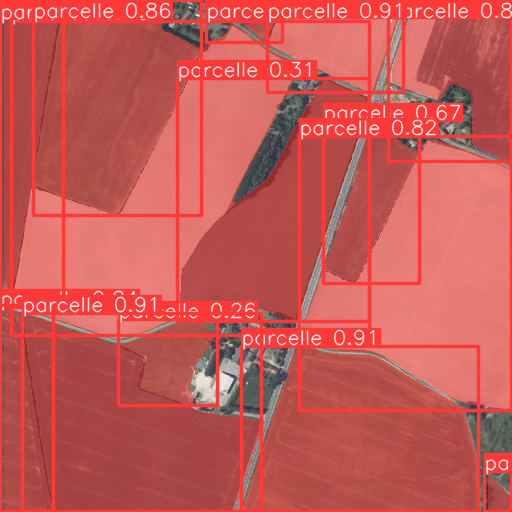

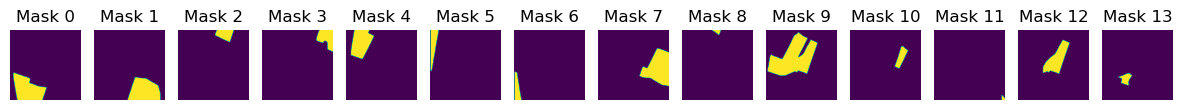

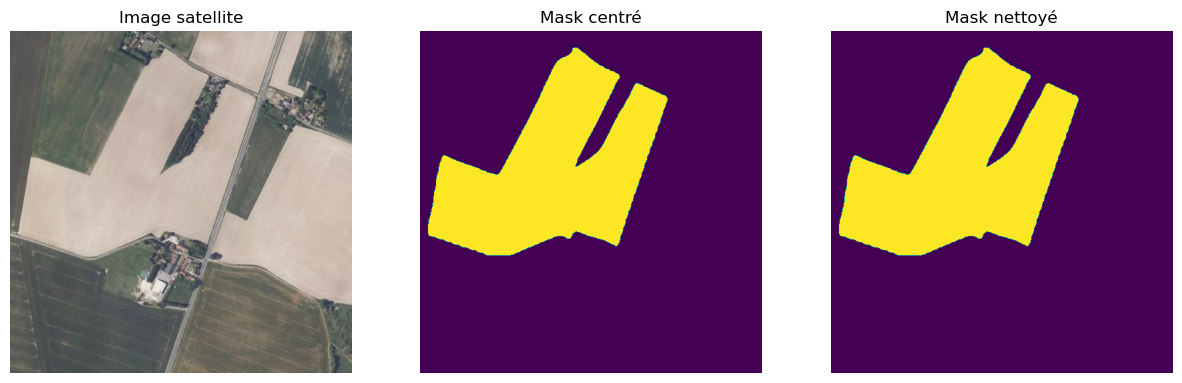

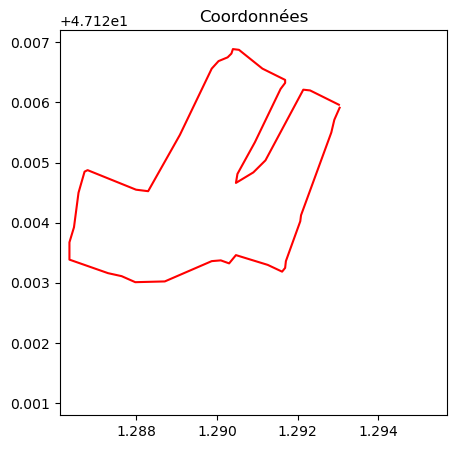

In [36]:
__main__()

Longitude de votre point :  1.2992
Latitude de votre point :  47.1293



0: 512x512 17 parcelles, 9.9ms
Speed: 0.8ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 512)
Nombre de masque centré : 1


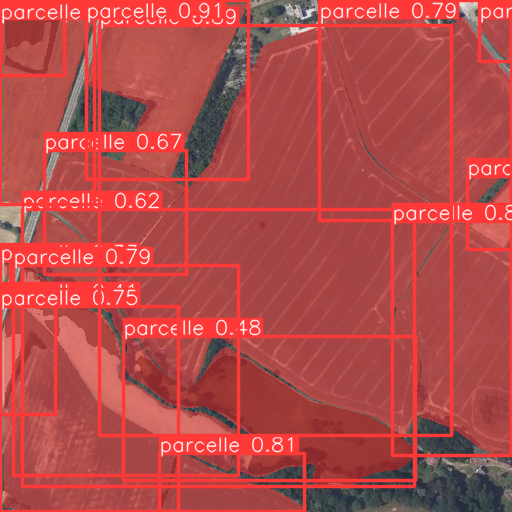

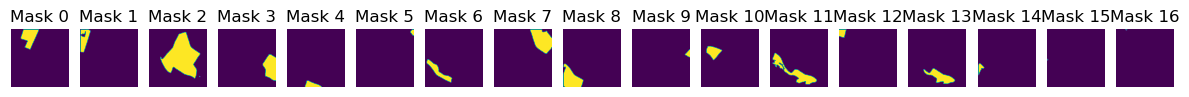

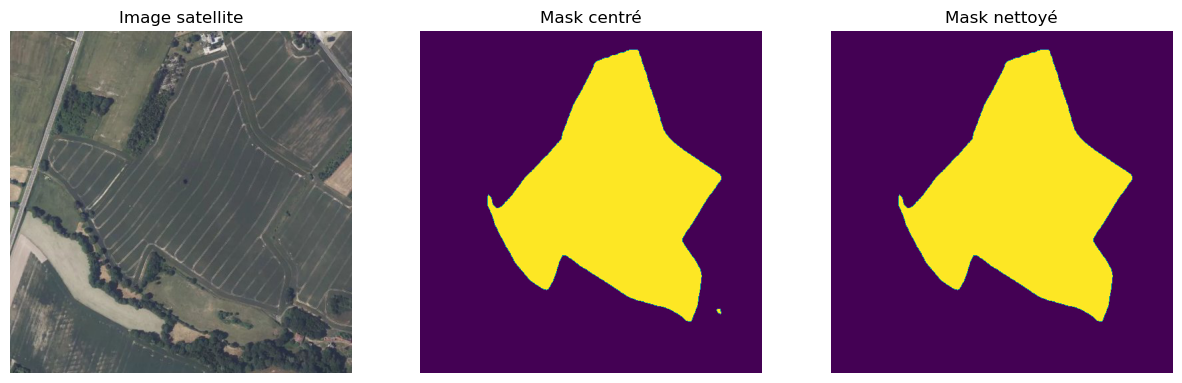

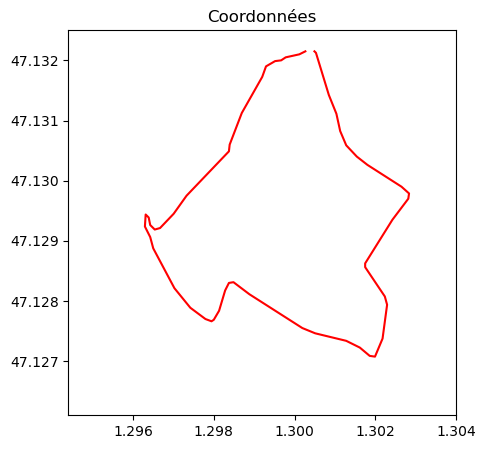

In [31]:
__main__()

Longitude de votre point :  1.3177
Latitude de votre point :  47.1276



0: 512x512 17 parcelles, 9.9ms
Speed: 0.8ms preprocess, 9.9ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 512)
Nombre de masque centré : 1


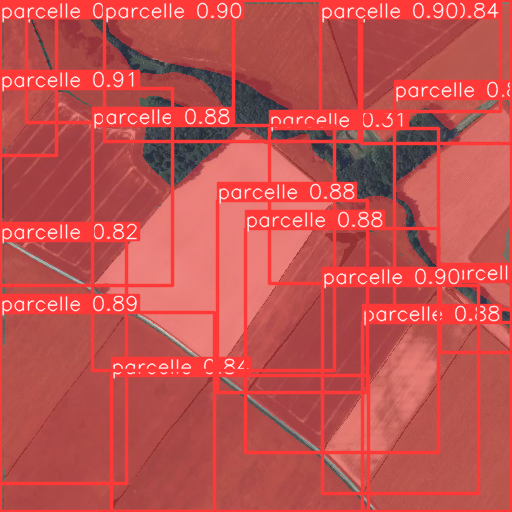

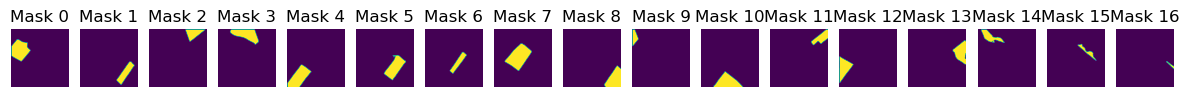

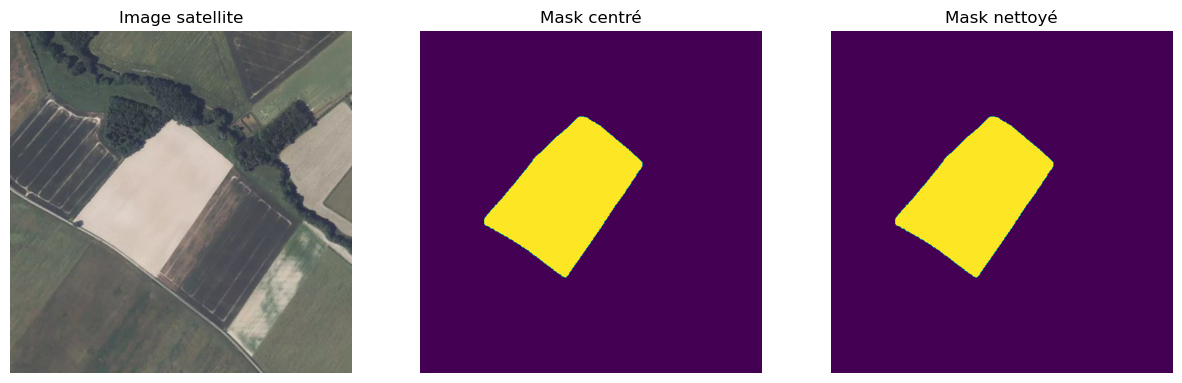

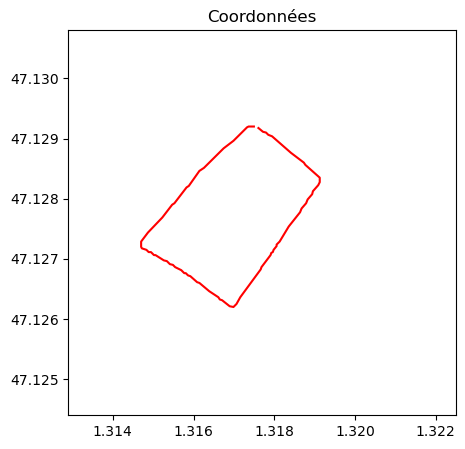

In [32]:
__main__()

Longitude de votre point :  0.3905
Latitude de votre point :  46.9348



0: 512x512 29 parcelles, 9.9ms
Speed: 0.9ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 512)
Nombre de masque centré : 1


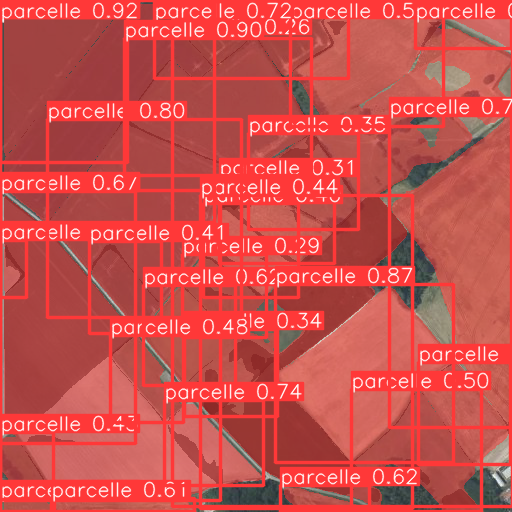

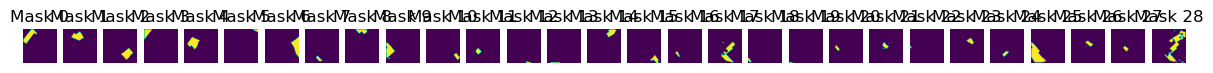

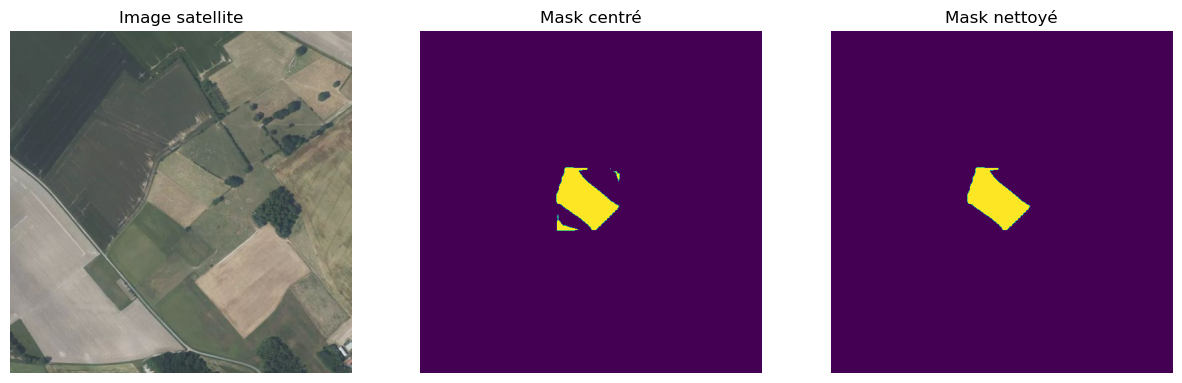

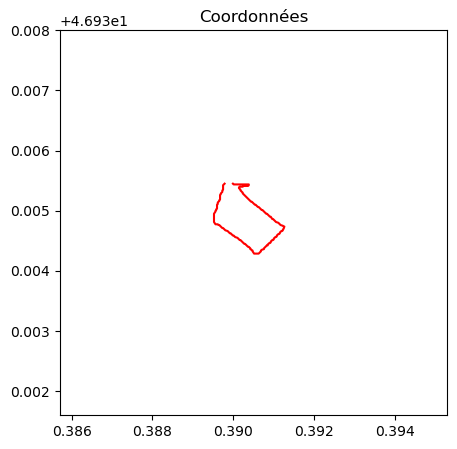

In [33]:
__main__()

Longitude de votre point :  1.1436
Latitude de votre point :  47.407



0: 512x512 16 parcelles, 9.9ms
Speed: 0.8ms preprocess, 9.9ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 512)
Nombre de masque centré : 1


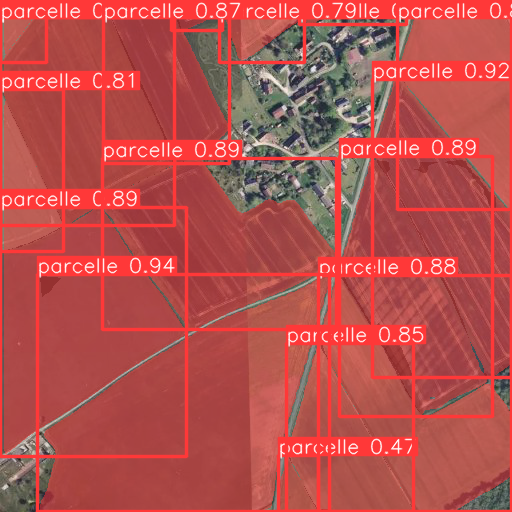

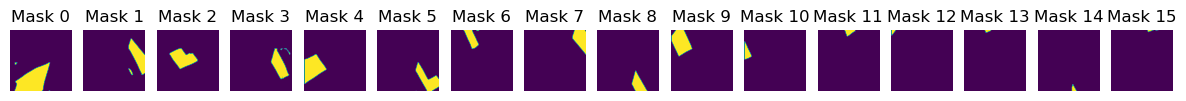

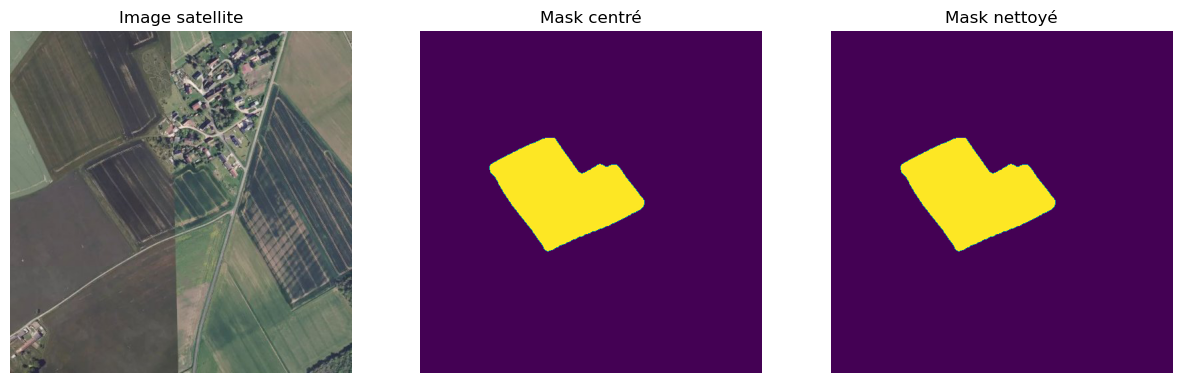

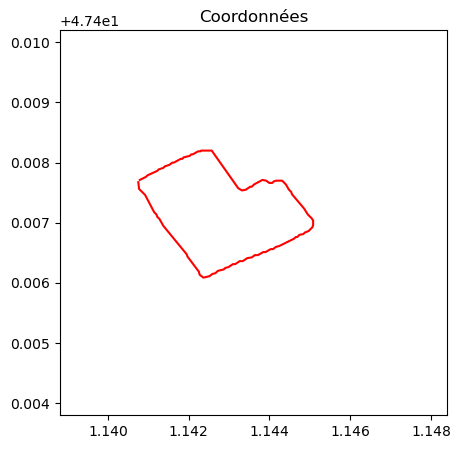

In [34]:
__main__()